In [1]:
import pandas as pd
import numpy as np
import datetime
import os, pathlib
import scipy.sparse
from COVIDScenarioPipeline.SEIR.utils import config
from COVIDScenarioPipeline.SEIR import seir, setup
import matplotlib.pyplot as plt
mobility_file = 'data/east-coast/MD_mobility_Feb16_Apr5.csv'

config_file = 'config_mobility_noChange.yml'

scenario = 'Uncontrolled_none_CSP'

config.set_file(config_file)

spatial_config = config["spatial_setup"]
spatial_base_path = pathlib.Path(spatial_config["base_path"].get())

s = setup.Setup(setup_name=config["name"].get() + "_" + str(scenario),
                        spatial_setup=setup.SpatialSetup(
                            setup_name=spatial_config["setup_name"].get(),
                            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
                            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
                            popnodes_key=spatial_config["popnodes"].get(),
                            nodenames_key=spatial_config["nodenames"].get(),
                            ti=config["start_date"].as_date(),
                            tf=config["end_date"].as_date()
                            
                        ),
                        nsim=1,
                        npi_scenario=scenario,
                        npi_config=config["interventions"]["settings"][scenario],
                        seeding_config=config["seeding"],
                        ti=config["start_date"].as_date(),
                        tf=config["end_date"].as_date(),
                        interactive=False,
                        write_csv=False,
                        write_parquet=True,
                        dt=config["dt"].as_number())

Loading CSV mobility file...


In [7]:
mobility_data = pd.read_csv(spatial_base_path / spatial_config["mobility"].get(), converters={'ori': lambda x: str(x), 'dest': lambda x: str(x)}, parse_dates=['date'])
mobility =  np.zeros(((s.tf - s.ti).days + 1, s.spatset.nnodes, s.spatset.nnodes))
for index, row in mobility_data.iterrows():
    mobility[(row['date'].date()-s.ti).days, s.spatset.nodenames.index(row['ori']), s.spatset.nodenames.index(row['dest'])] = row['amount']
    if (s.spatset.nodenames.index(row['ori']) == s.spatset.nodenames.index(row['dest'])):
        raise ValueError(f"Mobility fluxes with same origin and destination: '{row['ori']}' to {row['dest']} in long form matrix. This is not supported")

#for t in range((tf - ti).days+1):
#            if (self.mobility[t].sum() > self.popnodes).any(): 
#                print(f'Correcting matrix at time {t}...')
#                print(self.mobility[t].sum()-self.popnodes)
#                self.mobility[t][self.mobility[t].sum() > self.popnodes, :] = 0.1 * self.mobility[t][self.mobility[t].sum() > self.popnodes, :] *  self.popnodes/self.mobility[t].sum()

In [30]:
mobility[0][0,:]

array([  0.,   0.,   0.,  24., 223.,  89., 923.,  15.,   0.,   0.,   0.,
       144.,   0.,   0.,   0.,   4.,  10.,  25.,  65.,  10.,  74.,  29.,
        15.,  15.])

In [28]:
s.spatset.nodenames[0]

'24029'

In [22]:
mobility_data 

,Unnamed: 0,ori,dest,date,amount
0,1,24001,24003,2020-01-31,89
1,2,24001,24005,2020-01-31,43
2,3,24001,24013,2020-01-31,20
3,4,24001,24021,2020-01-31,108
4,5,24001,24023,2020-01-31,218
...,...,...,...,...,...
237211,237212,24033,24510,2020-12-31,3793
237212,237213,24035,24510,2020-12-31,195
237213,237214,24043,24510,2020-12-31,10
237214,237215,24045,24510,2020-12-31,30


In [26]:
np.where(mobility == 218)

(array([  0,   0,   1,   1,   2,   2,   3,   3,   4,   4,   5,   5,   6,
          6,   7,   7,   8,   8,   9,   9,  10,  10,  11,  11,  12,  12,
         13,  13,  14,  14,  15,  15,  16,  16,  17,  17,  18,  18,  19,
         19,  20,  20,  21,  21,  22,  22,  23,  23,  24,  24,  25,  25,
         26,  26,  27,  27,  28,  28,  29,  29,  30,  30,  31,  31,  32,
         32,  33,  33,  34,  34,  35,  35,  36,  36,  37,  37,  38,  38,
         39,  39,  40,  40,  41,  41,  42,  42,  43,  43,  44,  44,  45,
         45,  46,  46,  47,  47,  48,  48,  49,  49,  50,  50,  51,  51,
         52,  52,  53,  53,  54,  54,  55,  55,  56,  56,  57,  57,  58,
         58,  59,  59,  60,  60,  61,  61,  62,  62,  63,  63,  64,  64,
         65,  65,  66,  66,  67,  67,  68,  68,  69,  69,  70,  70,  71,
         71,  72,  72,  73,  73,  74,  74,  75,  75,  76,  76,  77,  77,
         78,  78,  79,  79,  80,  80,  81,  81,  82,  82,  83,  83,  84,
         84,  85,  85,  86,  86,  87,  87,  88,  88

In [3]:
ncomp = 7
S, E, I1, I2, I3, R, cumI = np.arange(ncomp)
percent_day_away = 0.5
it = 90*3
dt = 1/6
i = 0
popnodes = s.popnodes
beta = np.ones(s.nnodes) * 1 / 2.6 * 3 / 3
nnodes = s.nnodes
y = np.zeros((ncomp, nnodes))
alpha=1
y[I1] = np.ones(nnodes)* 100


p_expose = 1.0 - np.exp(-dt * (
              ((1 - percent_day_away * mobility[int(it%(1/dt))][i,:].sum()/ popnodes[i] ) * beta[i] * (y[I1][i] + y[I2][i] + y[I3][i])**alpha / popnodes[i] ) +  # Staying at home FoI
              (     percent_day_away * mobility[int(it%(1/dt))][i,:]/popnodes             * beta * (y[I1] + y[I2] + y[I3])).sum()
              )
            )
print(p_expose)

0.09620174217646738


0.6363237012683426

In [5]:
for i in range(nnodes):
    print(mobility[int(it%(1/dt))][i,:].sum()/ popnodes[i])

0.08243798583948111
0.04174537211938043
0.01870618334053228
0.04384082408486112
0.059124175890642956
0.11876025620665925
0.10592493409766099
0.11596766043456291
0.028540226670395675
0.05853251743917419
0.07128315760687916
0.02508209043794754
0.022624606518245192
0.07239800479014132
0.023604422437767076
0.06755058815082508
0.0950703772736037
0.07836994436865366
0.2866642283644217
0.17008644932819497
0.31135449730337333
0.16657660779922215
0.12946190729888118
0.11282629656803979


In [57]:
mobility[int(it%(1/dt))][i,:]/popnodes 

array([0.00173293, 0.00015111, 0.0017942 , 0.00196211, 0.00036291,
       0.00275263, 0.00803381, 0.00252653, 0.00390214, 0.01008598,
       0.00081027, 0.00038573, 0.00278647, 0.01260312, 0.02344163,
       0.02409444, 0.11181096, 0.00234861, 0.04861278, 0.01301018,
       0.00422249, 0.00483212, 0.05071923, 0.        ])

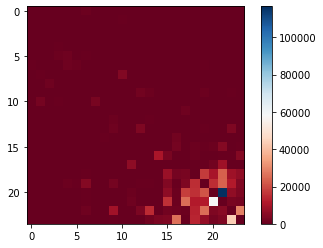

In [13]:
plt.imshow(mobility[0], cmap='RdBu')
plt.colorbar()

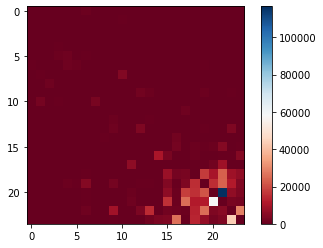

In [14]:
plt.imshow(mobility[-1], cmap='RdBu')
plt.colorbar()

In [26]:
row['date']

Timestamp('2020-04-05 00:00:00')

In [10]:
mobility_data

,id,ori,dest,FLOW,day,week,value,percent.effect.daily,percent.trip.daily,amount,percent.effect.weekly.med,percent.trip.weekly.med,adjusted.trip.count.weekly.med
0,1,24001,24001,48668,2020-02-16,7,-32,-0.32,0.68,33094.24,0.01,1.01,49154.68
1,2,24001,24003,54,2020-02-16,7,-32,-0.32,0.68,36.72,0.01,1.01,54.54
2,3,24001,24005,130,2020-02-16,7,-32,-0.32,0.68,88.40,0.01,1.01,131.30
3,4,24001,24013,12,2020-02-16,7,-32,-0.32,0.68,8.16,0.01,1.01,12.12
4,5,24001,24017,24,2020-02-16,7,-32,-0.32,0.68,16.32,0.01,1.01,24.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28796,24510,24029,112,2020-04-05,14,-42,-0.42,0.58,64.96,-0.53,0.47,52.64
28796,28797,24510,24035,134,2020-04-05,14,-42,-0.42,0.58,77.72,-0.53,0.47,62.98
28797,28798,24510,24039,7122,2020-04-05,14,-42,-0.42,0.58,4130.76,-0.53,0.47,3347.34
28798,28799,24510,24041,32146,2020-04-05,14,-42,-0.42,0.58,18644.68,-0.53,0.47,15108.62


In [3]:
s.mobility = np.zeros((s.t_span, s.nnodes, s.nnodes))

In [7]:
s.mobility = np.zeros((s.t_span, s.nnodes, s.nnodes))
for index, row in mobility_data.iterrows():
  s.mobility[s.spatset.nodenames.index(row['ori']),s.spatset.nodenames.index(row['dest'])] = row['amount']

In [69]:
seir.onerun_SEIR(1,s)

1

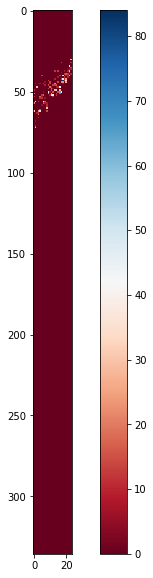

In [6]:
 importation = np.zeros((s.t_span+1, s.nnodes))

seeding = pd.read_csv(s.seeding_config["lambda_file"].as_str(),
                              converters={'place': lambda x: str(x)},
                              parse_dates=['date'])

for  _, row in seeding.iterrows():
            if row['place'] not in s.spatset.nodenames:
                raise ValueError(f"Invalid place '{row['place']}' in row {_ + 1} of seeding::lambda_file. Not found in geodata.")

            importation[(row['date'].date()-s.ti).days][s.spatset.nodenames.index(row['place'])] = np.random.poisson(row['amount'])
plt.figure(figsize=(10,10))
plt.imshow(importation, cmap='RdBu')
plt.colorbar()

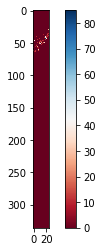

In [72]:
plt.imshow(importation, cmap='RdBu')
plt.colorbar()